In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import plotly.express as px

In [30]:
plt.style.use('ggplot')

In [31]:
df=pd.read_csv('Unemployment in America Per US State.csv')
states=geopandas.read_file(r"C:\Users\berid\python\geopandas\s_22mr22_states\s_22mr22.shp")
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')) 

In [32]:
df

FIPS Code     State/Area  Year  Month  \
0              1        Alabama  1976      1   
1              2         Alaska  1976      1   
2              4        Arizona  1976      1   
3              5       Arkansas  1976      1   
4              6     California  1976      1   
...          ...            ...   ...    ...   
29887         51       Virginia  2022     12   
29888         53     Washington  2022     12   
29889         54  West Virginia  2022     12   
29890         55      Wisconsin  2022     12   
29891         56        Wyoming  2022     12   

      Total Civilian Non-Institutional Population in State/Area  \
0                                           2,605,000             
1                                             232,000             
2                                           1,621,000             
3                                           1,536,000             
4                                          15,621,000             
...                                                  ...          
29887                                       6,862,585             
29888                                       6,254,253             
29889                                       1,434,789             
29890                                       4,753,700             
29891                                         460,134             

      Total Civilian Labor Force in State/Area  \
0                                 1,484,555      
1                                   160,183      
2                                   964,120      
3                                   889,044      
4                                 9,774,280      
...                                        ...   
29887                             4,470,272      
29888                             4,015,286      
29889                               784,323      
29890                             3,068,610      
29891                               293,595      

       Percent (%) of State/Area's Population Total Employment in State/Area  \
0                                        57.0                   1,386,023      
1                                        69.0                     148,820      
2                                        59.5                     865,871      
3                                        57.9                     824,395      
4                                        62.6                   8,875,685      
...                                       ...                            ...   
29887                                    65.1                   4,330,531      
29888                                    64.2                   3,832,769      
29889                                    54.7                     752,464      
29890                                    64.6                   2,976,670      
29891                                    63.8                     282,247      

       Percent (%) of Labor Force Employed in State/Area  \
0                                                   53.2   
1                                                   64.1   
2                                                   53.4   
3                                                   53.7   
4                                                   56.8   
...                                                  ...   
29887                                               63.1   
29888                                               61.3   
29889                                               52.4   
29890                                               62.6   
29891                                               61.3   

      Total Unemployment in State/Area  \
0                            98,532      
1                            11,363      
2                            98,249      
3                            64,649      
4                           898,595      
...                                ...   
29887                       139,741      
29888 

In [33]:
period=df['Year'].astype(str)+'-'+df['Month'].astype(str)
df.insert(0,'Period',period)

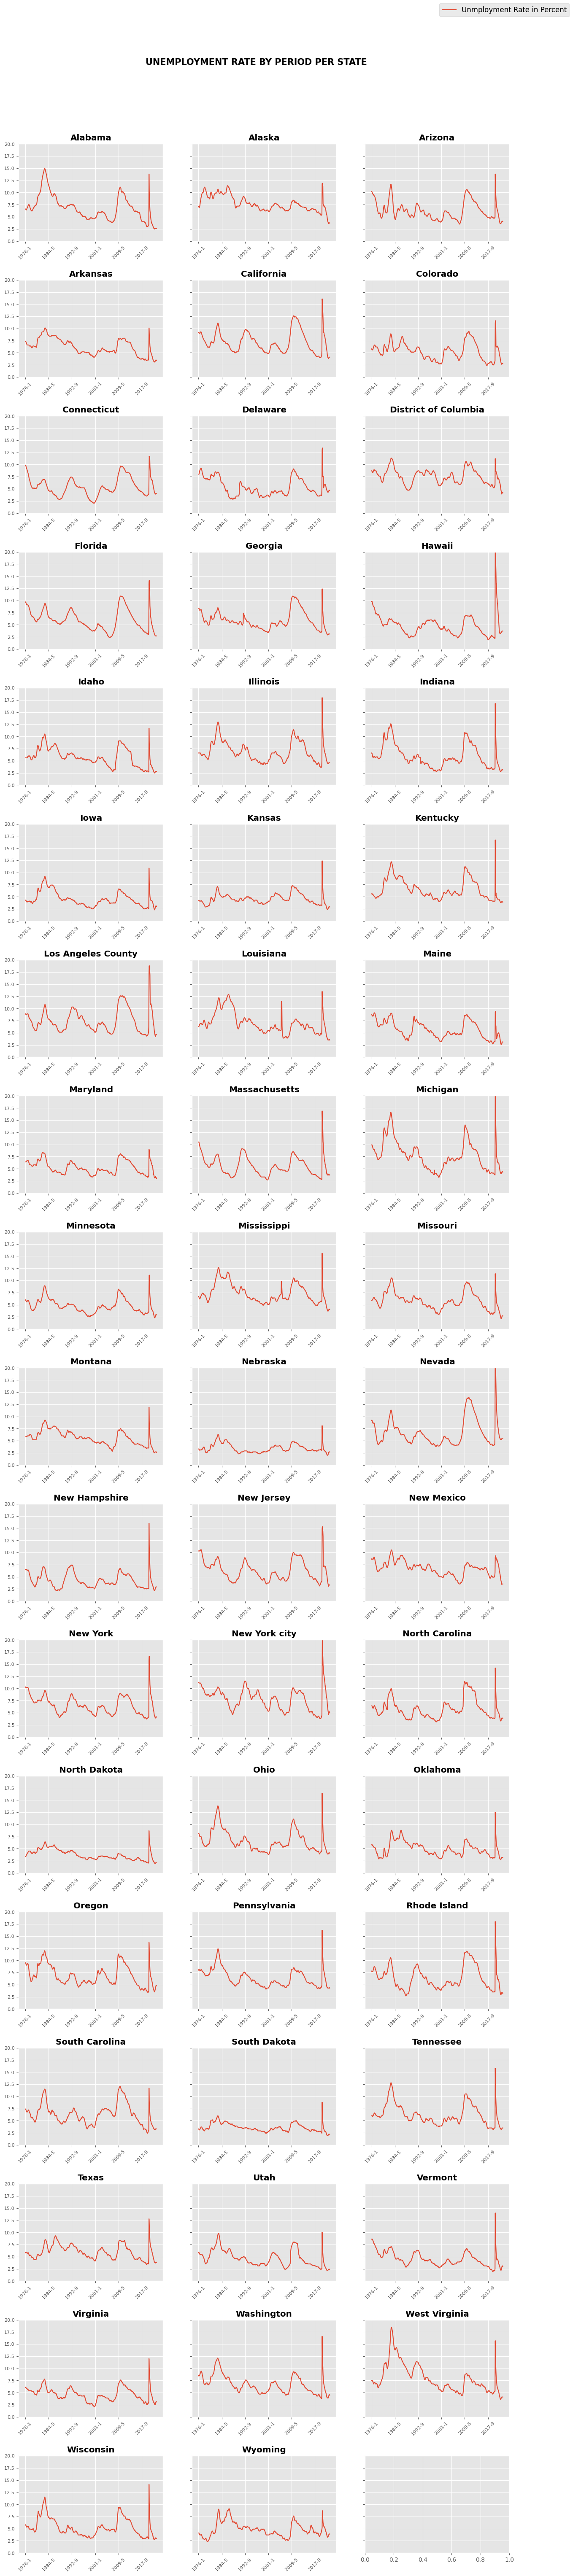

CPU times: total: 26.1 s
Wall time: 26.7 s


In [34]:
%%time

fig,axes=plt.subplots(18,3,figsize=(15,68),sharey=True,sharex=False)

for state,ax in zip(sorted(df['State/Area'].unique()),axes.ravel()):
    filt=df[df['State/Area']==state]
    filt.plot(ax=ax,x='Period',y=['Percent (%) of Labor Force Unemployed in State/Area'],
             legend=False,fontsize=8,rot=45,xlabel='')
    ax.set_title(state,fontweight='bold')
    ax.set_ylim(0,20)
fig.legend(['Unmployment Rate in Percent'],fontsize=12)                   
plt.suptitle('UNEMPLOYMENT RATE BY PERIOD PER STATE',fontweight='bold',size=15)
plt.subplots_adjust(hspace=0.4,top=0.95)
plt.show()

In [35]:
grouped=df.groupby(['FIPS Code','Period'])['Percent (%) of Labor Force Unemployed in State/Area'].mean().reset_index()
grouped['Period']=pd.to_datetime(grouped['Period']).dt.to_period('M')
grouped=grouped.sort_values(['FIPS Code','Period'])
grouped['FIPS Code']=grouped['FIPS Code'].astype(str).apply(lambda x:str(x) if len(x)>1 else '0'+str(x))

gdf=grouped.merge(states[['STATE','FIPS','geometry']],left_on='FIPS Code',right_on='FIPS')
gdf=geopandas.GeoDataFrame(gdf)

In [36]:
fig=px.choropleth(gdf,locations='STATE',locationmode='USA-states',scope='usa',
             color='Percent (%) of Labor Force Unemployed in State/Area',
             animation_frame='Period',range_color=[0,30])
fig.update_layout(title_text='UNEMPLOYMENT RATE BY STATE',title_font_size=25,
                 coloraxis_colorbar_title='Unemployment')
fig.write_html('unemployment.html')
fig.show()

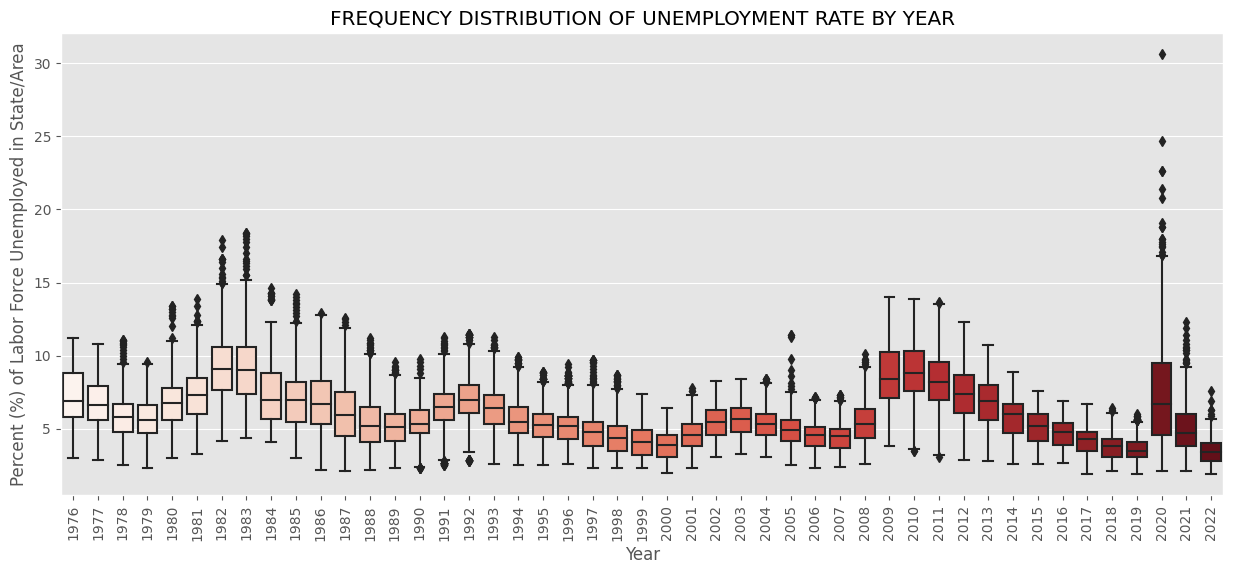

CPU times: total: 1.48 s
Wall time: 1.59 s


In [37]:
%%time

plt.figure(figsize=(15,6))
sns.boxplot(df,y='Percent (%) of Labor Force Unemployed in State/Area',x='Year',palette='Reds')
plt.xticks(ticks=[i for i in range(df['Year'].nunique())],labels=df['Year'].unique(),rotation=90)
plt.title('FREQUENCY DISTRIBUTION OF UNEMPLOYMENT RATE BY YEAR')
plt.show()

# ML

In [38]:
ndf=df.copy()

### ndf=ndf[ndf['State/Area']=='California']

In [39]:
ndf=ndf[['Year','Month','State/Area','Percent (%) of Labor Force Unemployed in State/Area']]
ndf.columns=['Year','Month','State','Rate']

In [40]:
for i in range(1,4):
    ndf[f'Prev{i}']=ndf.groupby(['State'])['Rate'].shift(i)
ndf=ndf.dropna()

In [41]:
ndf=ndf.sort_values(['State','Year','Month'])

In [42]:
dummies=pd.get_dummies(ndf['State'],prefix='State')
ndf=ndf.drop(columns='State')
ndf=pd.concat([ndf,dummies],axis=1)

In [43]:
ndf

Year  Month  Rate  Prev1  Prev2  Prev3  State_Alabama  State_Alaska  \
159    1976      4   6.5    6.6    6.6    6.6              1             0   
212    1976      5   6.4    6.5    6.6    6.6              1             0   
265    1976      6   6.5    6.4    6.5    6.6              1             0   
318    1976      7   6.6    6.5    6.4    6.5              1             0   
371    1976      8   6.7    6.6    6.5    6.4              1             0   
...     ...    ...   ...    ...    ...    ...            ...           ...   
29679  2022      8   3.7    3.5    3.4    3.3              0             0   
29732  2022      9   3.8    3.7    3.5    3.4              0             0   
29785  2022     10   3.9    3.8    3.7    3.5              0             0   
29838  2022     11   3.9    3.9    3.8    3.7              0             0   
29891  2022     12   3.9    3.9    3.9    3.8              0             0   

       State_Arizona  State_Arkansas  ...  State_South Dakota  \
159                0               0  ...                   0   
212                0               0  ...                   0   
265                0               0  ...                   0   
318                0               0  ...                   0   
371                0               0  ...                   0   
...              ...             ...  ...                 ...   
29679              0               0  ...                   0   
29732              0               0  ...                   0   
29785              0               0  ...                   0   
29838              0               0  ...                   0   
29891              0               0  ...                   0   

       State_Tennessee  State_Texas  State_Utah  State_Vermont  \
159                  0            0           0              0   
212                  0            0           0              0   
265                  0            0           0              0   
318                  0            0           0              0   
371                  0            0           0              0   
...                ...          ...         ...            ...   
29679                0            0           0              0   
29732                0            0           0              0   
29785                0            0           0              0   
29838                0            0           0              0   
29891                0            0           0              0   

       State_Virginia  State_Washington  State_West Virginia  State_Wisconsin  \
159                 0                 0                    0                0   
212                 0                 0                    0                0   
265                 0                 0                    0                0   
318                 0                 0                    0                0   
371                 0                 0                    0                0   
...               ...               ...                  ...              ...   
29679               0                 0                    0                0   
29732               0                 0                    0                0   
29785               0                 0                    0                0   
29838               0                 0                    0                0   
29891               0                 0                    0                0   

       State_Wyoming  
159                0  
212                0  
265                0  
318                0  
371                0  
...              ...  
29679              1  
29732              1  
29785              1  
29838              1  
29891              1  

[29733 rows x 59 columns]

In [44]:
#X=ndf.drop(columns='Rate')
#Y=ndf['Rate']

#from sklearn.model_selection import train_test_split

import math
border=math.ceil(len(ndf)*0.7)

train=ndf.iloc[:border,:]
test=ndf.iloc[border:,:]

xtrain,xtest,ytrain,ytest=train.drop(columns='Rate'),test.drop(columns='Rate'),train['Rate'],test['Rate']

In [45]:
import xgboost as xgb
from sklearn import metrics

In [46]:
model=xgb.XGBRegressor(max_depth=6,n_estimators=1000,learning_rate=0.1)

In [47]:
model.fit(xtrain,ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [48]:
train_prediction=model.predict(xtrain)
test_prediction=model.predict(xtest)

In [49]:
r2_train=metrics.r2_score(train_prediction,ytrain)
r2_test=metrics.r2_score(test_prediction,ytest)
mae_train=metrics.mean_absolute_error(train_prediction,ytrain)
mae_test=metrics.mean_absolute_error(test_prediction,ytest)
rmse_train=metrics.mean_squared_error(train_prediction,ytrain,squared=False)
rmse_test=metrics.mean_squared_error(test_prediction,ytest,squared=False)
print('R2, MAE ,RMSE for train and test data are:')
print(r2_train,r2_test)
print(mae_train,mae_test)
print(rmse_train,rmse_test)

R2, MAE ,RMSE for train and test data are:
0.9994035582735294 0.9908082202365804
0.03985767753160662 0.07087562111998796
0.054056873286658993 0.20694567705638262


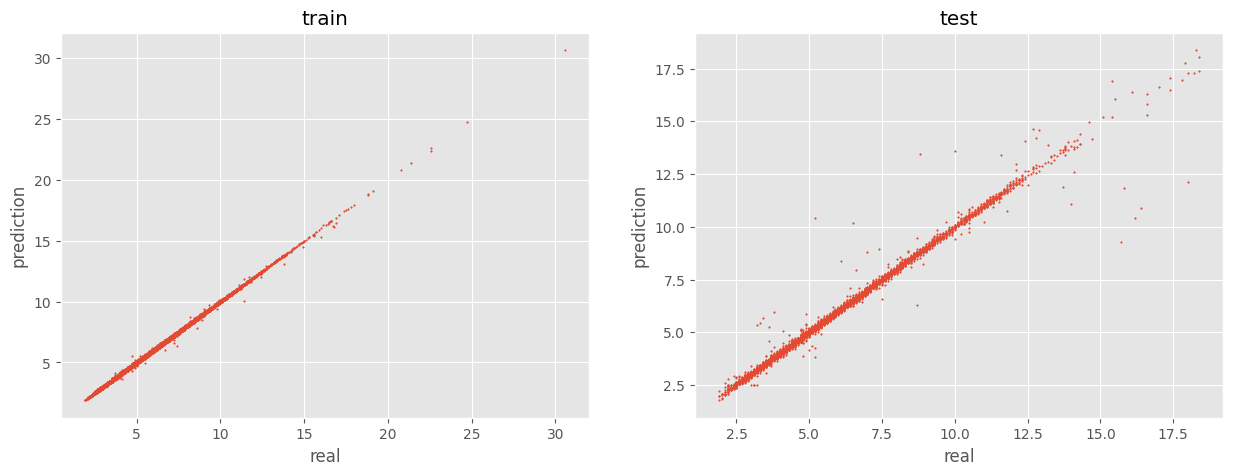

In [50]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.scatter(ytrain,train_prediction,s=1)
ax1.set_xlabel('real')
ax1.set_ylabel('prediction')
ax1.set_title('train')
ax2.scatter(ytest,test_prediction,s=1)
ax2.set_xlabel('real')
ax2.set_ylabel('prediction')
ax2.set_title('test')
plt.show()

# CHECKING 

In [51]:
train['Prediction']=train_prediction
test['Prediction']=test_prediction

data=pd.concat([train,test])

C:\Users\berid\AppData\Local\Temp\ipykernel_5572\370373875.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\berid\AppData\Local\Temp\ipykernel_5572\370373875.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
period=data['Year'].astype(str)+'-'+data['Month'].astype(str)
data.insert(0,'Period',period)

<AxesSubplot: xlabel='Period'>

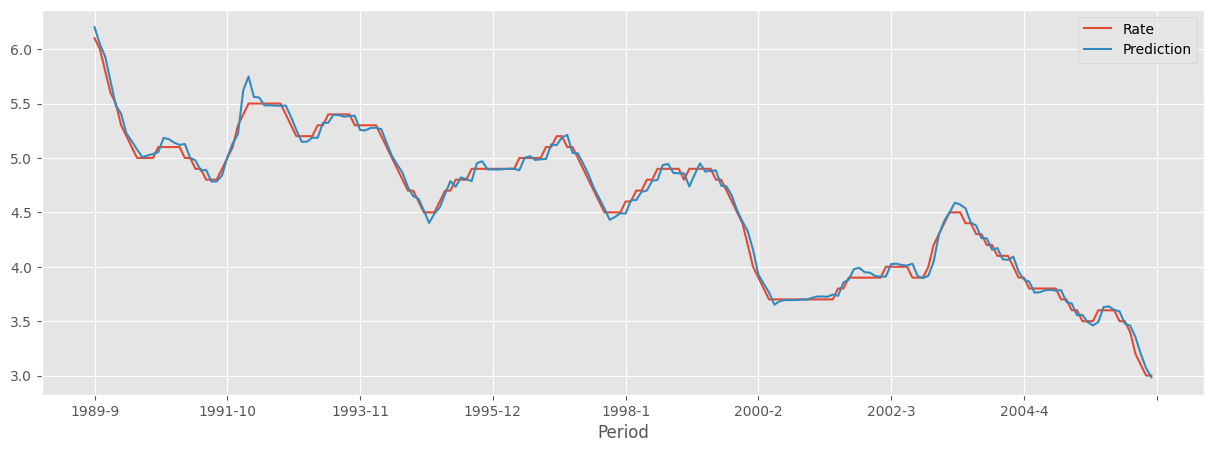

In [53]:
data.iloc[-400:-200,:].plot(figsize=(15,5),x='Period',y=['Rate','Prediction'])